In [1]:
%pylab inline
import os
import pandas as pd
from PIL import Image, ImageFilter, ImageOps
from sklearn import decomposition, cluster, svm, preprocessing, manifold
import cv2

Populating the interactive namespace from numpy and matplotlib


# 1) Get data

Gather our files paths

In [2]:
# Get local path
local_path = os.getcwd()

In [3]:
# List images folders
breeds_folders = [local_path + "/data/images/" + file_name for file_name in os.listdir(local_path + "/data/images") if os.path.isdir(local_path + "/data/images/" + file_name)]

In [4]:
# List breeds id and name
breeds_id = [breed_path.split("/")[-1].split("-")[0] for breed_path in breeds_folders]
breeds_name = [breed_path.split("/")[-1].split("-")[-1] for breed_path in breeds_folders]
breed_dict = dict(zip(breeds_id, breeds_name))

In [5]:
# List all images names
images = []
dog_id = []
breed_id = []
breed_name = []
full_path = []
for breed_folder in breeds_folders:
    # Get full pictures names
    files = [picture for picture in os.listdir(breed_folder) if picture.startswith("n")]
    images.extend(files)
    # Get pictures breed id
    breed_ids = [bids[0] for bids in list(map(lambda x: x.split("_"), files))]
    breed_id.extend(breed_ids)
    # Get dog id
    dog_ids = [did[0] for did in list(map(lambda x: x.split("_")[1].split("."), files))]
    dog_id.extend(dog_ids)
    # Convert breed id to breed name
    breed_names = [breed_dict[bid] for bid in breed_ids]
    breed_name.extend(breed_names)
    # Create full path to pictures
    full_paths = [breed_folder + "/" + file for file in files]
    full_path.extend(full_paths)

Now that we have our lists of data, gather into dataframe

In [6]:
data_mat = np.array([images, breed_id, breed_name, dog_id, full_path]).T

In [7]:
dogs_df = pd.DataFrame(data_mat, columns=['picture', 'breed_id', 'breed_name', 'breed_dog_id', 'pic_full_path'])

Have a look

In [8]:
dogs_df.sample(5)

,picture,breed_id,breed_name,breed_dog_id,pic_full_path
18,n02085620_1271.jpg,n02085620,Chihuahua,1271,D:\FORMATIONS\OCLR\0-PARCOURS-DATA_SCIENTIST\6...
2124,n02088364_12303.jpg,n02088364,beagle,12303,D:\FORMATIONS\OCLR\0-PARCOURS-DATA_SCIENTIST\6...
7206,n02095889_6382.jpg,n02095889,Sealyham_terrier,6382,D:\FORMATIONS\OCLR\0-PARCOURS-DATA_SCIENTIST\6...
4522,n02091635_663.jpg,n02091635,otterhound,663,D:\FORMATIONS\OCLR\0-PARCOURS-DATA_SCIENTIST\6...
8052,n02096585_1562.jpg,n02096585,Boston_bull,1562,D:\FORMATIONS\OCLR\0-PARCOURS-DATA_SCIENTIST\6...


# 2) Selecting train and test datasets

#### To begin with we will consider 5 breeds, 10 training pictures and 2 testing pictures for each breed

Select 5 random breeds

In [228]:
n_breeds = 5
breeds = pd.DataFrame(dogs_df.breed_id.unique()).sample(n_breeds, random_state=0).values

Select pictures for each breed

In [229]:
train_size = 20
test_size = 4
train_test_size = train_size + test_size
train_test_df = pd.DataFrame()
train_df = pd.DataFrame()
test_df = pd.DataFrame()
rmstate = np.random.RandomState(seed=0)
# For each sample breed
for breed in breeds:
    # Select breed sub df
    breed_df = dogs_df.loc[dogs_df['breed_id'] == breed[0]].loc[:, ['breed_name','pic_full_path']]
    breed_sample = breed_df.sample(train_test_size, random_state=0)
    # Shuffle index to get random train and test df
    breed_ind = breed_sample.index.values
    rmstate.shuffle(breed_ind)
    train_breed_ind = breed_ind[:train_size]
    test_breed_ind = breed_ind[train_size:]
    breed_train = breed_sample.loc[train_breed_ind, :]
    breed_test = breed_sample.loc[test_breed_ind, :]
    # Concatenate with main train-test df
    train_test_df = pd.concat((train_test_df, breed_sample))
    train_df = pd.concat((train_df, breed_train))
    test_df = pd.concat((test_df, breed_test))

# 3) Processing pictures

This first step aims to pre-process our pictures before extracting features

Steps are as follow :
- 1) Apply a Gaussian filter to delete noise by bluring picture
- 2) Apply histogram equalization
- 3) Transform picture into greyscale

#### Working on all training and testing sets for pre-processing

In [230]:
def dynamic_std_print(string_to_print):
    """
    Printing string on standard output and refreshing output line
    """
    sys.stdout.write('\r')
    sys.stdout.write(string_to_print)
    sys.stdout.flush()

# Initialize our features matrix
sift_features = np.empty((1, 128))
# Number if pictures
n_pic = train_test_df.shape[0]
n_feats = 0
pictures_descriptors = []

count = 1
for picture_id, picture_path in zip(train_test_df.index.values, train_test_df.pic_full_path.values):
    dynamic_std_print("Treating picture ({:d} / {:d})      ".format(count, n_pic))
    
    # Load the picture
    img = Image.open(picture_path)
    
    # Apply gaussian filter
    gaussian_img = img.filter(ImageFilter.GaussianBlur(radius=1))
    
    # Apply histogram equalization
    equalized_img = ImageOps.equalize(gaussian_img, mask=None)

    # Get picture's matrix
    img_mat = np.array(equalized_img)
    
    # Convert to greyscale
    img_grey_mat = cv2.cvtColor(img_mat, cv2.COLOR_BGR2GRAY)
    
    # Generate SIFT features
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img_grey_mat, None)
    pictures_descriptors.append(descriptors)
    
    # Number of features
    n_feat_img = len(keypoints)
    n_feats = n_feats + n_feat_img
    
    # Concatenate descriptors
    sift_features = np.concatenate((sift_features, descriptors))
    
    count += 1

# Remove 1st empty column
sift_features = sift_features[1:, :]

Treating picture (120 / 120)      

# 3.2) Visualizing features

We need to reduce our features dimension in order to be able to visualize them

#### Apply PCA

In [177]:
ratios = []
components = np.arange(2, 107, 5)
for i in components:
    dynamic_std_print("Treating {:d}".format(i))
    visu_pca = decomposition.PCA(n_components=i)
    visu_pca.fit(sift_features)
    ratios.append(visu_pca.explained_variance_ratio_.sum())

Treating 102

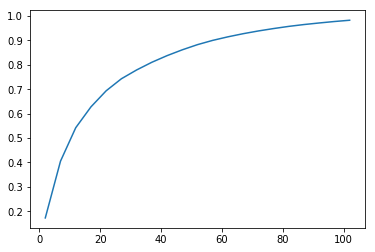

In [178]:
plt.plot(components, ratios);

In [179]:
# Transform features with PCA
visu_pca = decomposition.PCA(n_components=50)
visu_pca.fit(sift_features)
sift_feats_pca = visu_pca.transform(sift_features)

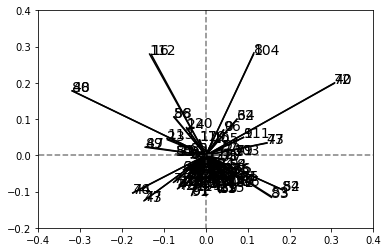

In [15]:
pcs = visu_pca.components_
for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, i, fontsize='14')
# Afficher une ligne horizontale y=0
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')
# Afficher une ligne verticale x=0
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')
plt.xlim([-0.4, 0.4])
plt.ylim([-0.2, 0.4]);

Several features seem greatly correlated or negatively correlated

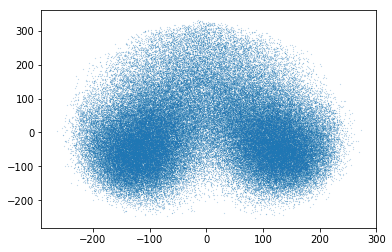

In [16]:
plt.scatter(sift_feats_pca[:,0], sift_feats_pca[:,1], s=0.01);

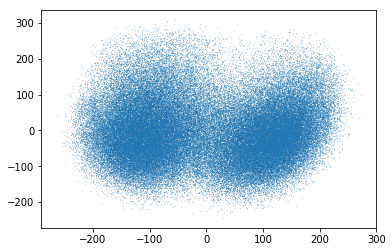

In [17]:
plt.scatter(sift_feats_pca[:,0], sift_feats_pca[:,2], s=0.01);

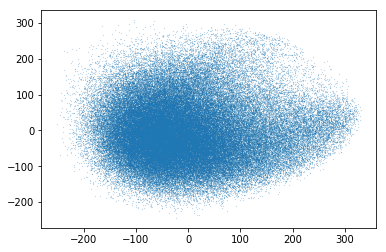

In [18]:
plt.scatter(sift_feats_pca[:,1], sift_feats_pca[:,2], s=0.01);

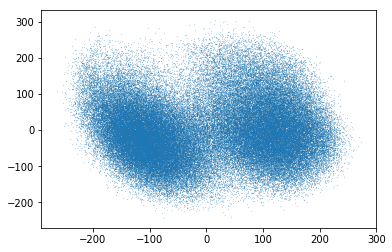

In [19]:
plt.scatter(sift_feats_pca[:,0], sift_feats_pca[:,3], s=0.01);

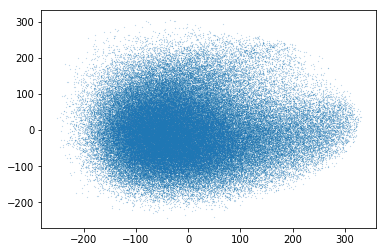

In [20]:
plt.scatter(sift_feats_pca[:,1], sift_feats_pca[:,3], s=0.01);

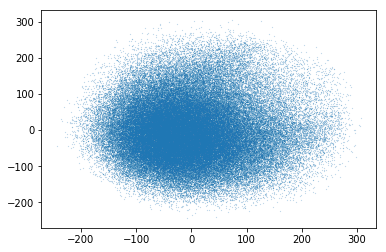

In [21]:
plt.scatter(sift_feats_pca[:,2], sift_feats_pca[:,3], s=0.01);

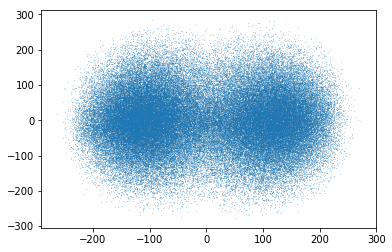

In [22]:
plt.scatter(sift_feats_pca[:,0], sift_feats_pca[:,4], s=0.01);

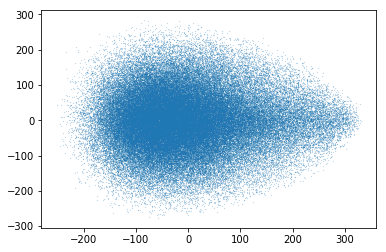

In [23]:
plt.scatter(sift_feats_pca[:,1], sift_feats_pca[:,4], s=0.01);

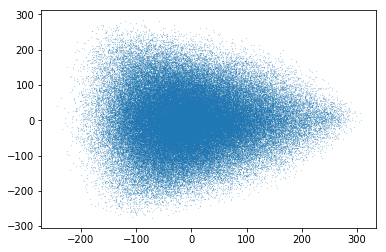

In [24]:
plt.scatter(sift_feats_pca[:,2], sift_feats_pca[:,4], s=0.01);

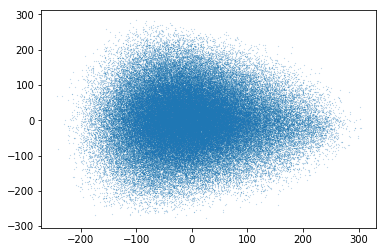

In [25]:
plt.scatter(sift_feats_pca[:,3], sift_feats_pca[:,4], s=0.01);

#### Apply tSNE

In [63]:
idx = np.arange(0, len(sift_features))
rmstate = np.random.RandomState(0)
rmstate.shuffle(idx)
idx = idx[:10000]

In [79]:
tsne = manifold.TSNE(n_components=2, perplexity=10, n_iter=250, init='pca', verbose=1)
sift_features_tsne = tsne.fit_transform(sift_features[:10000, :])

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.080s...
[t-SNE] Computed neighbors for 10000 samples in 29.274s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 79.012228
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.614708
[t-SNE] Error after 251 iterations: 17976931348623157081452742373170435679807

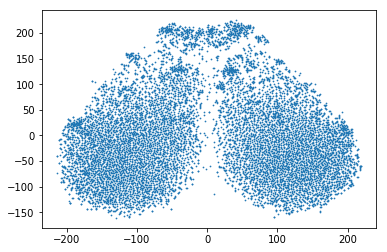

In [69]:
# 10000 random features, perp = 30, n_iter = 1000
plt.scatter(sift_features_tsne[:,0], sift_features_tsne[:,1], s=0.5);

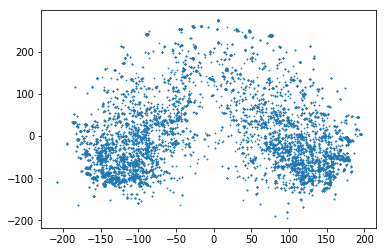

In [67]:
# 10000 random features, perp = 30, n_iter = 250
plt.scatter(sift_features_tsne[:,0], sift_features_tsne[:,1], s=0.5);

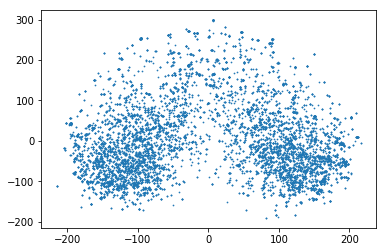

In [65]:
# 10000 random features, perp = 10, n_iter = 250
plt.scatter(sift_features_tsne[:,0], sift_features_tsne[:,1], s=0.5);

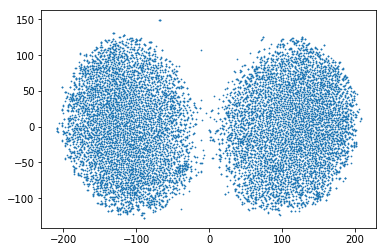

In [43]:
# first 10000 features, perp = 30, n_iter = 1000
plt.scatter(sift_features_tsne[:,0], sift_features_tsne[:,1], s=0.5);

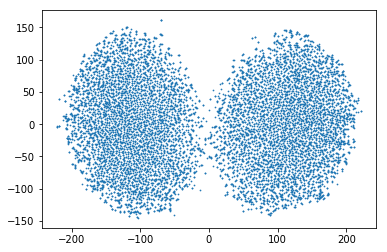

In [41]:
# first 10000 features, perp = 10, n_iter = 1000
plt.scatter(sift_features_tsne[:,0], sift_features_tsne[:,1], s=0.5);

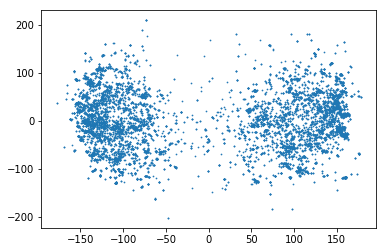

In [39]:
# first 10000 features, perp = 50, n_iter = 250
plt.scatter(sift_features_tsne[:,0], sift_features_tsne[:,1], s=0.5);

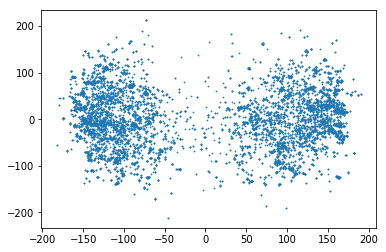

In [78]:
# first 10000 features, perp = 30, n_iter = 250
plt.scatter(sift_features_tsne[:,0], sift_features_tsne[:,1], s=0.5);

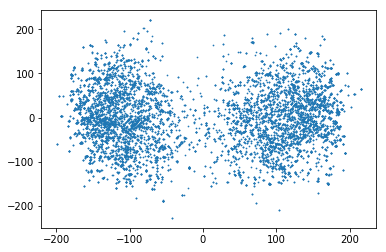

In [80]:
# first 10000 features, perp = 10, n_iter = 250
plt.scatter(sift_features_tsne[:,0], sift_features_tsne[:,1], s=0.5);

# 4) Output Bag of Visual Words

Now that we have our features we will turn those into Bags of Visual Words through a KMeans clustering which cluster centers will be our Visual Words

Problem is : training our clusters takes a lot of computational capabilities.

Solution : Apply PCA dimensionality reduction before clustering

In [231]:
sift_features.shape

(225811, 128)

#### Apply PCA for dimensionality reduction

In [232]:
sift_components = np.arange(50, 120, 5)
ok_var = 0.9
for i in sift_components:
    dynamic_std_print("Treating {:d}".format(i))
    sift_pca = decomposition.PCA(n_components=i)
    sift_pca.fit(sift_features)
    if sift_pca.explained_variance_ratio_.sum() >= ok_var:
        break
    
# n_comp_pca = 57
n_comp_pca = i
pca_bow = decomposition.PCA(n_components=n_comp_pca)
pca_bow.fit(sift_features)
pca_bow.explained_variance_ratio_.sum()

Treating 60

0.9092568695554873

We look to explain 90% of the features variance

In [233]:
sift_features_reduced = pca_bow.transform(sift_features)

#### Gather our features in bag of visuals words through kmeans clustering

In [234]:
n_clust = int(np.floor(np.sqrt(sift_features.shape[0])))
n_clust

475

In [235]:
kmeans = cluster.KMeans(n_clusters=n_clust, verbose=1, n_jobs=-1, algorithm='full')
kmeans.fit(sift_features_reduced);

The clusters centers are our visual words

In [236]:
kmeans.cluster_centers_.shape

(475, 60)

In [237]:
colors = kmeans.predict(sift_features_reduced)

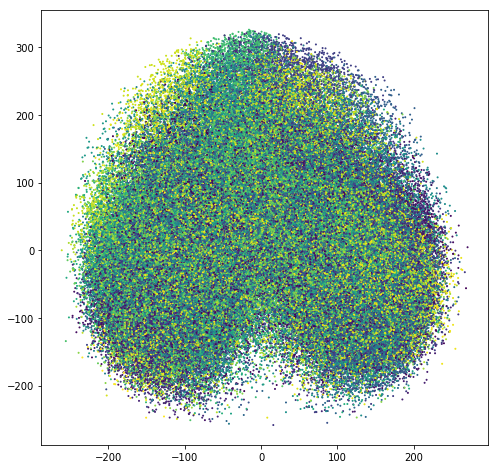

In [238]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(sift_features_reduced[:, 0], sift_features_reduced[:, 1], s=1, c=colors);

# 5) Create histograms for each picture

We now create histograms showing our features frequency in each picture

#### Apply PCA for dimensionality reduction

In [239]:
pictures_descriptors_red = []
for img_desc in pictures_descriptors:
    pictures_descriptors_red.append(pca_bow.transform(img_desc))

#### Get histograms from reduced pictures SIFT descriptors

In [240]:
histograms = []
for img_desc_red in pictures_descriptors_red:
    predict_kmeans = kmeans.predict(img_desc_red)
    hist, bins = np.histogram(predict_kmeans, bins=n_clust)
    histograms.append(hist)

# 6) Separate into train and test datasets

Now that we have our explanatory features : our histograms, we can learn from it and try to predict breeds, first separate our histograms into training and testing datasets

In [217]:
histo_df = pd.DataFrame(histograms)
histo_df.index = train_test_df.index

In [218]:
new_train_df = pd.concat((train_df, histo_df[histo_df.index.isin(train_df.index)]), axis=1)
new_train_df = new_train_df.drop(labels=['pic_full_path'], axis=1)
new_test_df = pd.concat((test_df, histo_df[histo_df.index.isin(test_df.index)]), axis=1)
new_test_df = new_test_df.drop(labels=['pic_full_path'], axis=1)

# 7) Train classifier

Learn on train dataset

In [219]:
breeds_unique = new_train_df.breed_name.unique()
le = preprocessing.LabelEncoder()
le.fit(breeds_unique);

In [220]:
target_training = le.transform(new_train_df.breed_name.values).reshape(-1, 1)
target_testing = le.transform(new_test_df.breed_name.values).reshape(-1, 1)

In [221]:
training_svm = svm.LinearSVC()
training_svm.fit(new_train_df.loc[:, new_train_df.columns != 'breed_name'].values, target_training)

C:\Users\simon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [222]:
prediction = training_svm.predict(new_test_df.loc[:, new_test_df.columns != 'breed_name'].values)
prediction_breeds = le.inverse_transform(prediction)

C:\Users\simon\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [223]:
res_mat = np.concatenate((prediction_breeds.reshape(-1,1), new_test_df.breed_name.values.reshape(-1,1)), axis=1)
res_df = pd.DataFrame(res_mat, columns=['Predicted', 'True_Breed'])
res_df['Accurate'] = res_df.Predicted == res_df.True_Breed
res_df

,Predicted,True_Breed,Accurate
0,Irish_terrier,Scotch_terrier,False
1,Maltese_dog,Scotch_terrier,False
2,Rhodesian_ridgeback,Scotch_terrier,False
3,Bedlington_terrier,Scotch_terrier,False
4,Dandie_Dinmont,French_bulldog,False
5,Ibizan_hound,French_bulldog,False
6,toy_terrier,French_bulldog,False
7,African_hunting_dog,French_bulldog,False
8,toy_terrier,Great_Dane,False
9,African_hunting_dog,Great_Dane,False


In [224]:
classification_score = training_svm.score(new_test_df.loc[:, new_test_df.columns != 'breed_name'].values, target_testing)
print("The model achieves a classification score of %.2f" % classification_score)

The model achieves a classification score of 0.09


In [227]:
train_test_df.shape

(480, 2)